In [114]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import os
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


def get_a1(gamma_A, gamma_B):
    return gamma_A + gamma_B

def get_a2(gamma_A, gamma_B, nu_AA, nu_BB):
    return gamma_A * gamma_B + nu_AA + nu_BB

def get_a3(gamma_A, gamma_B, nu_AA, nu_BB):
    return gamma_A * nu_BB + gamma_B * nu_AA

def get_a4(nu_AA, nu_BB, nu_AB_BA):
    return nu_AA * nu_BB - nu_AB_BA

def get_Delta2(gamma_A, gamma_B, nu_AA, nu_BB):
    a1 = get_a1(gamma_A, gamma_B)
    a2 = get_a2(gamma_A, gamma_B, nu_AA, nu_BB)
    a3 = get_a3(gamma_A, gamma_B, nu_AA, nu_BB)
    return a1 * a2 - a3

def get_Delta3(gamma_A, gamma_B, nu_AA, nu_BB, nu_AB_BA):
    a1 = get_a1(gamma_A, gamma_B)
    a2 = get_a2(gamma_A, gamma_B, nu_AA, nu_BB)
    a3 = get_a3(gamma_A, gamma_B, nu_AA, nu_BB)
    a4 = get_a4(nu_AA, nu_BB, nu_AB_BA)
    Delta2 = a1 * a2 - a3
    return a3 * Delta2 - a1**2 * a4

In [115]:
def get_gamma_nu(sigma_D, sigma_v, Pe, w1, w2, wc, q, ll=3./20, simple_gamma=False):
    if simple_gamma:
        gamma_A = sigma_D / q
        gamma_B = 1 / q
    else:
        gamma_A = sigma_D / q + (Pe * sigma_v) ** 2 / (16 * sigma_D) * q
        gamma_B = 1 / q + Pe ** 2 / 16 * q
    nu_AA = 0.5 * (Pe * sigma_v)**2 * (1 + (w1-1) * (1-ll*q**2))
    nu_BB = 0.5 * Pe**2 * (1 + (w2-1) * (1-ll*q**2))
    nu_AB_BA = 0.25 * Pe**4 * sigma_v**2 * wc * (1-ll*q**2)**2
    return gamma_A, gamma_B, nu_AA, nu_BB, nu_AB_BA

def get_gamma(sigma_D, sigma_v, Pe, q, simple_gamma=False):
    if simple_gamma:
        gamma_A = sigma_D / q
        gamma_B = 1 / q
    else:
        gamma_A = sigma_D / q + (Pe * sigma_v) ** 2 / (16 * sigma_D) * q
        gamma_B = 1 / q + Pe ** 2 / 16 * q
    return gamma_A, gamma_B

def get_nu(sigma_v, Pe, w1, w2, wc, q, ll=3./20):
    nu_AA = 0.5 * (Pe * sigma_v)**2 * (1 + (w1-1)*(1-ll*q**2))
    nu_BB = 0.5 * Pe**2 * (1 + (w2-1)*(1-ll*q**2))
    nu_AB_BA = 0.25 * Pe**4 * sigma_v**2 * wc * (1-ll*q**2)**2
    return nu_AA, nu_BB, nu_AB_BA



In [116]:
def find_long_instabi(sigma_D, sigma_v, Pe, w1, w2, wc, q0=1e-4, ll=3./20, simple_gamma=False):
    gamma_A, gamma_B, nu_AA, nu_BB, nu_AB_BA = get_gamma_nu(sigma_D, sigma_v, Pe, w1, w2, wc, q0, ll=ll, simple_gamma=simple_gamma)
    # a3 = get_a3(gamma_A, gamma_B, nu_AA, nu_BB)
    a4 = get_a4(nu_AA, nu_BB, nu_AB_BA)
    Delta_2 = get_Delta2(gamma_A, gamma_B, nu_AA, nu_BB)
    Delta_3 = get_Delta3(gamma_A, gamma_B, nu_AA, nu_BB, nu_AB_BA)
    # long-wave instabilities
    mask_LI = np.logical_or(a4 <= 0, np.logical_or(Delta_2 <= 0, Delta_3 <= 0))
    # long-wave stabilities
    mask_LS = np.logical_and(a4 > 0, np.logical_and(Delta_2 > 0, Delta_3 > 0))
    sigma_0 = sigma_D / sigma_v ** 2
    mask_LOI = np.logical_and(mask_LI, (w1-sigma_0 * w2)**2 < 4*(-sigma_0 * wc))
    mask_LSI = np.logical_and(mask_LI, (w1-sigma_0 * w2)**2 >= 4*(-sigma_0 * wc))
    return mask_LS, mask_LOI, mask_LSI

def find_first_zero(f_arr, q_arr):
    for i, q in enumerate(q_arr):
        if f_arr[i] < 0:
            return q
    return 0

def find_first_zeros(a4, Delta3, q_arr):
    q0_a4, q0_Delta3 = 0, 0
    for i, q in enumerate(q_arr):
        if a4[i] < 0 and Delta3[i] > 0:
            q0_a4 = q
            break
        elif a4[i] > 0 and Delta3[i] < 0:
            q0_Delta3 = q
            break
        elif a4[i] < 0 and Delta3[i] < 0:
            q0_a4 = q
            q0_Delta3 = q
            break
    return q0_a4, q0_Delta3


def find_short_instabi(sigma_D, sigma_v, Pe, w1, w2, wc, qmin=1e-4, qmax=np.sqrt(20/3), Nq=100, ll=3./20, simple_gamma=False):
    q_arr = np.linspace(qmin, qmax, Nq, endpoint=False)
    gamma_A_q, gamma_B_q, nu_AA_q, nu_BB_q, nu_AB_BA_q = get_gamma_nu(
        sigma_D, sigma_v, Pe, w1, w2, wc, q_arr, ll=ll, simple_gamma=simple_gamma)
    a4_q = get_a4(nu_AA_q, nu_BB_q, nu_AB_BA_q)
    Delta3_q = get_Delta3(gamma_A_q, gamma_B_q, nu_AA_q, nu_BB_q, nu_AB_BA_q)
    q0_a4, q0_D3 = 0., 0.
    if np.min(a4_q) < 0 or np.min(Delta3_q) < 0:
        q0_a4, q0_D3 = find_first_zeros(a4_q, Delta3_q, q_arr)
    return q0_a4, q0_D3

def find_contours(state):
    contours = {}
    contours["LWS"] = measure.find_contours(state==1)
    contours["LWO"] = measure.find_contours(state==2)
    contours["SWS"] = measure.find_contours(state==3)
    contours["SWO"] = measure.find_contours(state==4)
    return contours

In [117]:
def get_PD_w1_w2_data(sigma_D, sigma_v, Pe, wc, extent=[-8, 8, -8, 8],
                      qmin=1e-5, qmax=1, Nq=200, resolution=1000, overwrite=False):
    fout = "d:/code/PDE/Linear_instability/data/PD_w1_w2/sD%g_sv%g_Pe%g_wc%g_qm%g_r%g.npz" % (
            sigma_D, sigma_v, Pe, wc, qmax, resolution
        )
    if not overwrite and os.path.exists(fout):
        with np.load(fout, "rb") as data:
            return data["extent"], data["state"], data["q_range"]
    else:
        nrows, ncols = resolution, resolution
        w1, w2 = np.meshgrid(
            np.linspace(extent[0], extent[1], ncols),
            np.linspace(extent[2], extent[3], nrows)
        )
        mask_LS, mask_LOI, mask_LSI = find_long_instabi(sigma_D, sigma_v, Pe, w1, w2, wc)
        q0_a4, q0_Delta3 = np.zeros((2, nrows, ncols))
        for row in range(nrows):
                for col in range(ncols):
                    if mask_LS[row, col]:
                        q0_a4[row, col], q0_Delta3[row, col] = find_short_instabi(
                            sigma_D, sigma_v, Pe, w1[row, col], w2[row, col], wc)
        state = np.zeros((nrows, ncols), np.byte)
        state[mask_LSI] = 1
        state[mask_LOI] = 2
        state[q0_a4 > 0] = 3
        state[q0_Delta3 > 0] = 4
        q_range = np.array([qmin, qmax, Nq])
        np.savez_compressed(fout, extent=extent, state=state, q_range=q_range)
        return extent, state, q_range


def plot_PD_w1_w2(state, extent, xlim=None, ylim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True, constrained_layout=True)
        flag_show = True
    else:
        flag_show = False

    nrows, ncols = state.shape
    # ax.imshow(state, origin="lower", extent=extent)
    contours = find_contours(state)

    for contour in contours["SWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        ax.fill(x, y, c="tab:green", alpha=0.5)
    
    for contour in contours["SWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        ax.fill(x, y, c="tab:orange", alpha=0.5)

    for contour in contours["LWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        # ax.fill(x, y, c="tab:blue", alpha=0.5)
        if (contour[:, 0].max() == nrows-1):
            ax.fill_betweenx(y, extent[0], x, color="tab:blue", alpha=0.5)
        elif (contour[:, 1].max() == ncols - 1):
            ax.fill_between(x, extent[2], y, color="tab:blue", alpha=0.5)

    for contour in contours["LWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        ax.fill(x, y, c="tab:pink", alpha=0.5)
    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])

    if flag_show:
        plt.show()
        plt.close()

# sigma_D = 1
# sigma_v = 4
# Pe = 1
# wc = -4
# extent, state, q_range = get_PD_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2, Nq=500, resolution=1000)
# plot_PD_w1_w2(state, extent)

# extent, state, q_range = get_PD_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2, Nq=500, resolution=4000)
# plot_PD_w1_w2(state, extent)

In [118]:
def get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, extent=[-8, 8, -8, 8],
                            qmin=1e-5, qmax=2.5, Nq=400, resolution=1000, overwrite=False):
    fout = "d:/code/PDE/Linear_instability/data/PD_tilde_w1_w2/sD%g_sv%g_Pe%g_wc%g_qm%g_r%g.npz" % (
            sigma_D, sigma_v, Pe, wc, qmax, resolution
        )
    if not overwrite and os.path.exists(fout):
        with np.load(fout, "rb") as data:
            return data["extent"], data["state"], data["q_range"]
    else:
        nrows, ncols = resolution, resolution
        tilde_w1, tilde_w2 = np.meshgrid(
            np.linspace(extent[0], extent[1], ncols),
            np.linspace(extent[2], extent[3], nrows)
        )
        sigma = sigma_D / sigma_v**2
        w1 = np.sqrt( sigma * np.abs(wc)) * tilde_w1
        w2 = np.sqrt(np.abs(wc) / sigma) * tilde_w2 
        mask_LS, mask_LOI, mask_LSI = find_long_instabi(sigma_D, sigma_v, Pe, w1, w2, wc)
        q0_a4, q0_Delta3 = np.zeros((2, nrows, ncols))
        for row in range(nrows):
                for col in range(ncols):
                    if mask_LS[row, col]:
                        q0_a4[row, col], q0_Delta3[row, col] = find_short_instabi(
                            sigma_D, sigma_v, Pe, w1[row, col], w2[row, col], wc)
        state = np.zeros((nrows, ncols), np.byte)
        state[mask_LSI] = 1
        state[mask_LOI] = 2
        state[q0_a4 > 0] = 3
        state[q0_Delta3 > 0] = 4
        q_range = np.array([qmin, qmax, Nq])
        print(fout)
        np.savez_compressed(fout, extent=extent, state=state, q_range=q_range)
        return extent, state, q_range


def plot_PD_tilde_w1_w2(state, extent, xlim=None, ylim=None, ax=None, only_SWO=False, legend_loc="upper left", legend_font_size="medium"):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True, constrained_layout=True)
        flag_show = True
    else:
        flag_show = False

    nrows, ncols = state.shape
    # ax.imshow(state, origin="lower", extent=extent)
    contours = find_contours(state)

    fill_list = []
    if not only_SWO:
        fill1 = None
        for contour in contours["SWS"]:
            x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
            y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
            fill1, = ax.fill(x, y, c="tab:orange", alpha=0.5, label="short-wave stationary")
        if fill1 is not None:
            fill_list.append(fill1)

        for contour in contours["LWS"]:
            x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
            y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
            # ax.fill(x, y, c="tab:blue", alpha=0.5)
            if (contour[:, 0].max() == nrows-1):
                fill2 = ax.fill_betweenx(y, extent[0], x, color="tab:blue", alpha=0.5, label="long-wave\nstationary")
            elif (contour[:, 1].max() == ncols - 1):
                fill2 = ax.fill_between(x, extent[2], y, color="tab:blue", alpha=0.5, label="long-wave\nstationary")
        fill_list.append(fill2)

        for contour in contours["LWO"]:
            x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
            y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]

            x_new = np.zeros(x.size + 1)
            y_new = np.zeros(y.size + 1)
            x_new[:x.size] = x
            y_new[:y.size] = y
            x_new[-1] = extent[0]
            y_new[-1] = extent[2]
            fill3, = ax.fill(x_new, y_new, c="tab:pink", alpha=0.5, label="long-wave\noscillatory")
        fill_list.append(fill3)
    x_SWO, y_SWO = None, None
    for contour in contours["SWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        fill4, = ax.fill(x, y, c="tab:green", alpha=0.25, label="short-wave\noscillatory")
        if x_SWO is None:
            x_SWO, y_SWO = x, y
        elif x_SWO.size < x.size:
            x_SWO, y_SWO = x, y
    fill_list.append(fill4)
    
    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    # if not only_SWO:
    #     fill_legend = ax.legend(handles=fill_list, loc=legend_loc, fontsize=legend_font_size, borderpad=0.3, labelspacing=0.3)
    #     ax.add_artist(fill_legend)

    if flag_show:
        plt.show()
        plt.close()
    return x_SWO, y_SWO


# Pe = 1
# wc = -1
# extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
# plot_PD_tilde_w1_w2(state, extent)


# Pe = 0.1
# wc = -1
# extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
# plot_PD_tilde_w1_w2(state, extent)


# Pe = 100
# wc = -1
# extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
# plot_PD_tilde_w1_w2(state, extent)

# xlim = [-4, 4]
# ylim = [-4, 4]

# Pe = 10
# wc = -1
# extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
# x, y = plot_PD_tilde_w1_w2(state, extent, xlim, ylim)



In [119]:
def get_PD_wc_Pe_data(sigma_D, sigma_v, w1, w2, extent=[-10, 0, 0, 11],
                      qmin=1e-5, qmax=1, Nq=200, resolution=1000, overwrite=False, ll=np.sqrt(3./20)):
    fout = "d:/code/PDE/Linear_instability/data/PD_wc_Pe/sD%g_sv%g_w1%g_w2%g_qm%g_r%g.npz" % (
            sigma_D, sigma_v, w1, w2, qmax, resolution
        )
    if not overwrite and os.path.exists(fout):
        with np.load(fout, "rb") as data:
            return data["extent"], data["state"], data["q_range"]
    else:
        nrows, ncols = resolution, resolution
        wc, Pe = np.meshgrid(
            np.linspace(extent[0], extent[1], ncols),
            np.linspace(extent[2], extent[3], nrows)
        )
        # wc_1D = np.logspace(-2, 2, ncols)
        # Pe_1D = np.logspace(-2, 2, nrows)
        # wc, Pe = np.meshgrid(
        #     -wc_1D[::-1],
        #     Pe_1D
        # )
        mask_LS, mask_LOI, mask_LSI = find_long_instabi(sigma_D, sigma_v, Pe, w1, w2, wc)
        q0_a4, q0_Delta3 = np.zeros((2, nrows, ncols))
        for row in range(nrows):
                for col in range(ncols):
                    if mask_LS[row, col]:
                        q0_a4[row, col], q0_Delta3[row, col] = find_short_instabi(
                            sigma_D, sigma_v, Pe[row, col], w1, w2, wc[row, col], qmin=qmin, qmax=qmax, ll=ll)
        state = np.zeros((nrows, ncols), np.byte)
        state[mask_LSI] = 1
        state[mask_LOI] = 2
        state[q0_a4 > 0] = 3
        state[q0_Delta3 > 0] = 4
        q_range = np.array([qmin, qmax, Nq])
        np.savez_compressed(fout, extent=extent, state=state, q_range=q_range)
        return extent, state, q_range


def plot_PD_wc_Pe(state, extent, xlim=None, ylim=None, ax=None, alpha=0.25):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True, constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    nrows, ncols = state.shape
    contours = find_contours(state)
    for contour in contours["SWO"]:
        print(contour)
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        ax.fill_between(x, y, y.max(), color="tab:green", alpha=alpha)
    # ax.imshow(state, origin="lower", extent=extent)
    # ax.plot(x, y, ".")
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    if xlim is None:
            xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])

    # if flag_show:
    #     plt.show()
    #     plt.close()
    
    # plt.loglog(-x, y)
    # # plt.plot(x, y)
    # plt.show()
    # plt.close()
    

# extent, state, q_range = get_PD_wc_Pe_data(1, 1, 1, 1, overwrite=False)
# plot_PD_wc_Pe(state, extent)

    

In [120]:
def PD_Pe_vs_chi(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False

    extent, state, q_range = get_PD_wc_Pe_data(1, 1, 1, 1, overwrite=False, resolution=2000, qmax=1, ll=0)
    plot_PD_wc_Pe(state, extent, ax=ax, xlim=[-4.1, 0], ylim=[0, 10.5])
    with np.load("data/PD_wc_Pe/Dr_etaAB.npz", "r") as data:
        Dr, eta_AB, state, vel_var = data["Dr"], data["eta_AB"], data["state"], data["vel_var"]

        vmin, vmax = vel_var.min(), vel_var.max()
        print("val:", vmin, vmax)
        mask_D = state == 1
        mask_H = state == 0
        chi = -eta_AB**2
        Pe = 1 / Dr
        # ax.plot(chi[mask_D], Pe[mask_D], "^")
        # ax.plot(chi[mask_H], Pe[mask_H], "o")
        sca1 = ax.scatter(chi[mask_D], Pe[mask_D], s=30, c=vel_var[mask_D], marker="^", vmin=vmin, vmax=0.1, label="travelling bands", cmap="cividis")
        sca2 = ax.scatter(chi[mask_H], Pe[mask_H], s=30, c=vel_var[mask_H], marker="x", vmin=vmin, vmax=0.1, label="homogenous phase", cmap="cividis")

    # ll = 3/20
    # chi = np.linspace(-4.1, -0.1)
    # Pe = np.sqrt(-ll/chi)
    # ax.plot(chi, Pe, "--", c="tab:red", label=r"$-\chi \mathrm{Pe}=\ell^2$")
    # reduced_line = onset_instability_reduced_model(ax, q_max=1, ll=0)
    cax = ax.inset_axes([0.15, 0.38, 0.6, 0.05])
    cb = plt.colorbar(sca1, extend="max", orientation="horizontal", cax=cax)
    # ax.set_xlabel(r"$\chi$", fontsize="x-large")
    # ax.set_ylabel(r"${\rm Pe}$", fontsize="x-large")
    # cb.set_label(r"${\rm Var}(v)\equiv \langle \left[ \langle v_i^2(t)\rangle_i - \langle v_i(t)\rangle_i^2 \right]\rangle_t$", fontsize="x-large")
    cb.set_label(r"${\rm Var}(v)$", fontsize="x-large")

    # ax.set_title(r"$\chi_A=\chi_B=1, \sigma=\sigma_v=\sigma_D=1$", fontsize="x-large")

    patches = [
            sca1, sca2,
            mpatches.Patch(color='tab:green', label='SOI', alpha=0.2),
            # reduced_line
            ]
    legend1 = ax.legend(handles=patches, loc=(0.1, 0.5), fontsize="x-large", borderpad=0.2)
    if flag_show:
        plt.show()
        # plt.savefig("fig/S1.pdf")
        plt.close()

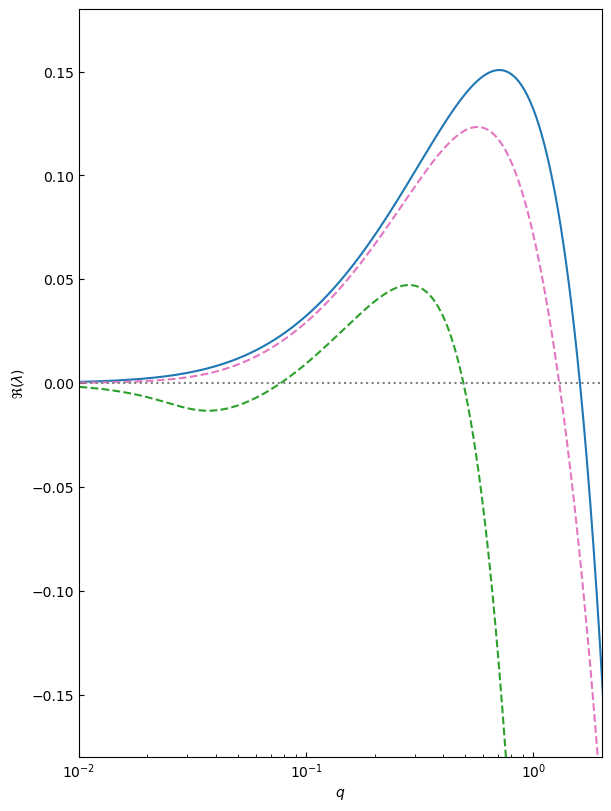

In [121]:
import sys
sys.path.append('..')
from NRQS_Turing import DMatrix_w_surface_tension, DMatrix
# q_arr = np.linspace(1e-6, np.sqrt(20/3), 1000)

def plot_lambda(x, y, ax, threshold=1e-8, c="tab:blue"):
    mask_r = np.abs(y.imag) <= threshold
    turning_pts = [0]
    states = [mask_r[0]]
    for i in range(x.size):
        if states[-1] != mask_r[i]:
            turning_pts.append(i)
            states.append(mask_r[i])
    turning_pts.append(x.size)
    line = None
    for i, s in enumerate(states):
        beg, end = turning_pts[i], turning_pts[i+1]
        xx = x[beg:end]
        yy = y[beg:end].real
        if s:
            ls = "-"
        else:
            ls = "--"
        if line is None:
            ax.plot(xx, yy, ls, c=c)
        else:
            ax.plot(xx, yy, ls, c=c)


def show_dispersion_relation(ax=None):
    q_arr = np.logspace(-2, np.log10(np.sqrt(20/3)), 1000, endpoint=False)
    eta_AB = 1
    eta_BA = -1
    wc = eta_AB * eta_BA
    sigma = 1
    Dr = 0.05
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 8), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False

    phiA = 1
    phiB = 1

    eta_AA = 1
    eta_BB = -2
    M = DMatrix_w_surface_tension(eta_AA, eta_AB, eta_BA, eta_BB, phiA=phiA, phiB=phiB, Dr_A=Dr, Dr_B=Dr, bar_vA=1, bar_vB=1, w_v2_over_q=True)
    lamb = M.get_lambda_q(q_arr).max(axis=1)
    plot_lambda(q_arr, lamb, ax, c="tab:blue")

    eta_AA = -1.2
    eta_BB = -1.2
    M = DMatrix_w_surface_tension(eta_AA, eta_AB, eta_BA, eta_BB, phiA=phiA, phiB=phiB, Dr_A=Dr, Dr_B=Dr, bar_vA=1, bar_vB=1, w_v2_over_q=True)
    lamb = M.get_lambda_q(q_arr).max(axis=1)
    plot_lambda(q_arr, lamb, ax, c="tab:pink")

    eta_AA = -0.1
    eta_BB = -0.1
    M = DMatrix_w_surface_tension(eta_AA, eta_AB, eta_BA, eta_BB, phiA=phiA, phiB=phiB, Dr_A=Dr, Dr_B=Dr, bar_vA=1, bar_vB=1, w_v2_over_q=True)
    lamb = M.get_lambda_q(q_arr).max(axis=1)
    plot_lambda(q_arr, lamb * 2, ax, c="tab:green")

    ax.set_xscale("log")
    ax.axhline(0, c="tab:grey", linestyle="dotted")
    ax.set_xlim(q_arr[0], 2)
    ax.set_ylim(-0.18, 0.18)


    if flag_show:
        ax.set_xlabel(r"$q$")
        ax.set_ylabel(r"$\Re(\lambda)$")
        plt.show()
        plt.close()

show_dispersion_relation()

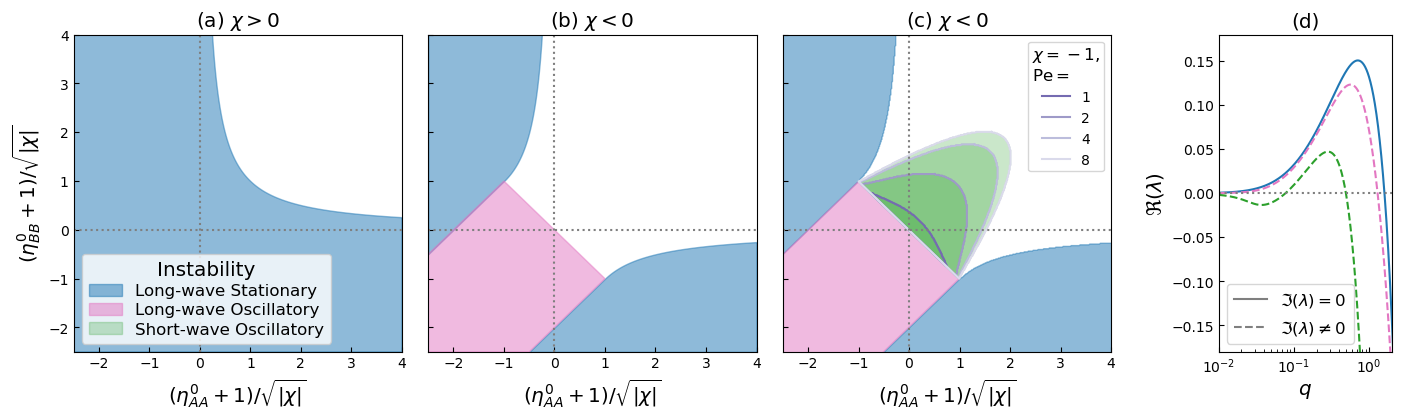

In [126]:
import matplotlib.patches as mpatches
from matplotlib import image as mpimg
from matplotlib import colormaps
import os

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
fig = plt.figure(figsize=(14, 4))
subfigs = fig.subfigures(1, 2, wspace=0.001, hspace=0.001, width_ratios=[12, 2])
(ax1, ax2, ax3) = subfigs[0].subplots(1, 3, sharex=True, sharey=True)
xlim = [-2.5, 4]
ylim = [-2.5, 4]

# ax1: chi >= 0
x1 = np.linspace(1e-5, xlim[1], 1000)
y1 = 1 / x1
x2 = np.zeros(x1.size + 1)
y2 = np.zeros(y1.size + 1)
x2[1:] = x1
y2[1:] = y1
x2[0] = xlim[0]
y2[0] = ylim[0]
ax1.fill_between(x2, ylim[0], y2, color="tab:blue", alpha=0.5)

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(xlim[0], xlim[1])
# ax1.set_xticks([-4, -2, 0, 2, 4])

patches = [mpatches.Patch(color='tab:blue', label='Long-wave Stationary', alpha=0.5),
           mpatches.Patch(color='tab:pink', label='Long-wave Oscillatory',alpha=0.5),
        #    mpatches.Patch(color='tab:orange', label='Short-wave\nStationary\nInstability (SSI)', alpha=0.5),
           mpatches.Patch(color='tab:green', label='Short-wave Oscillatory', alpha=0.25),
        ]
ax1.legend(handles=patches, loc="lower left", fontsize="large", frameon=True, labelspacing=0.25, title="Instability", title_fontsize="x-large")

# ax2: chi < 0
# long-wave stationary
x1 = ylim[0] + 2
w1 = np.linspace(x1, xlim[1], 500)
w2 = np.zeros_like(w1)
w2[w1<1] = w1[w1<1] - 2
w2[w1>=1] = -1 / w1[w1>=1]
fill1 = ax2.fill_between(w1, ylim[0], w2, color="tab:blue", alpha=0.5, label="long-wave stationary")
ax2.fill_betweenx(w1, xlim[0], w2, color="tab:blue", alpha=0.5)

# long-wave oscillatory
x = np.array([xlim[0], x1, 1, -1, xlim[0]])
y = np.array([ylim[0], ylim[0], -1, 1, x1])
fill2,= ax2.fill(x, y, color="tab:pink", alpha=0.5, label="long-wave oscillatory")


Pe = 1
sigma_D=1
sigma_v = 1
wc = -1
extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
x, y = plot_PD_tilde_w1_w2(state, extent, xlim, ylim, ax=ax3, legend_loc=(0.28, 0.68), legend_font_size="medium")
# cm = plt.cm.get_cmap('tab20c')
cm = colormaps['tab20c']
line, = ax3.plot(x, y, "-", c=cm.colors[12], label="%g" % Pe)
line_list = [line]
for i, Pe in enumerate([2, 4, 8]):
    extent, state, q_range = get_PD_tilde_w1_w2_data(sigma_D, sigma_v, Pe, wc, qmax=2.5, Nq=500, resolution=1000)
    x, y = plot_PD_tilde_w1_w2(state, extent, xlim, ylim, ax=ax3, only_SWO=True)
    line, = ax3.plot(x, y, c=cm.colors[i+13], label="%g" % Pe)
    line_list.append(line)

ax3.legend(handles=line_list, title="$\\chi=-1,$\n${\\rm Pe}=$", loc="upper right", fontsize="medium", borderpad=0.3, title_fontsize="large")

subfigs[0].subplots_adjust(left=0.055, bottom=0.14, right=0.92, top=0.933, wspace=0.08, hspace=0)


label_font_size = "x-large"
# xlabel = r"$\frac{(\bar{\eta}_{AA}+1)\sigma_v}{\sqrt{|\chi|}}$"
# ylabel = r"$\frac{\bar{\eta}_{BB}+1}{\sigma_v \sqrt{|\chi|}}$"
xlabel = r"$(\eta^0_{AA}+1)/\sqrt{|\chi|}$"
ylabel = r"$(\eta^0_{BB}+1)/\sqrt{|\chi|}$"
ax1.set_xlabel(xlabel, fontsize=label_font_size)
ax1.set_ylabel(ylabel, fontsize=label_font_size)
ax2.set_xlabel(xlabel, fontsize=label_font_size)
ax3.set_xlabel(xlabel, fontsize=label_font_size)

for ax in [ax1, ax2, ax3]:
   ax.axhline(0, linestyle=":", color="tab:grey")
   ax.axvline(0, linestyle=":", color="tab:grey")

ax4 = subfigs[1].subplots(1, 1)
show_dispersion_relation(ax4)
ax4.set_xlabel(r"$q$", fontsize=label_font_size)

ax1.set_title(r"(a) $\chi>0$", fontsize=label_font_size)
ax2.set_title(r"(b) $\chi<0$", fontsize=label_font_size)
ax3.set_title(r"(c) $\chi<0$", fontsize=label_font_size)
ax4.set_title(r"(d)", fontsize=label_font_size)

# ax4.text(0.04, 0.8, r"$\Re(\lambda)$", rotation=90, transform=ax4.transAxes, fontsize=label_font_size)
ax4.set_ylabel(r"$\Re(\lambda)$", fontsize=label_font_size)

solid_line = mlines.Line2D([], [], color='tab:grey', linestyle="-", label=r'$\Im(\lambda)=0$')
dashed_line = mlines.Line2D([], [], color='tab:grey', linestyle='--', label=r'$\Im(\lambda)\neq0$')

ax4.legend(handles=[solid_line, dashed_line], loc="lower left", fontsize="large")

plt.show()
# plt.savefig("fig/FIG1.pdf", dpi=100)
plt.close()